# Brain Tumor MRI

In [1]:
import os
import zipfile
import numpy as np
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.utils import Sequence
import shap

In [2]:
# Unzip dataset
dataset_path = 'Brain Tumor MRI.zip'  # Update with your dataset zip file name
extract_path = 'Brain_Tumor_MRI_Extracted'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}")
else:
    print(f"Dataset already extracted at {extract_path}")

# Define paths
training_path = os.path.join(extract_path, 'Training')
testing_path = os.path.join(extract_path, 'Testing')

# Check the classes in the dataset
print("Training Classes:", os.listdir(training_path))
print("Testing Classes:", os.listdir(testing_path))


Dataset already extracted at Brain_Tumor_MRI_Extracted
Training Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# Data Preprocessing

def crop_img(img):
    """
    Crop the brain region by finding contours in the image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return img[y:y+h, x:x+w]

def preprocess_images(source_dir, target_dir, img_size=256):
    """
    Preprocess images by cropping and resizing.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for subfolder in os.listdir(source_dir):
        subfolder_path = os.path.join(source_dir, subfolder)
        save_path = os.path.join(target_dir, subfolder)
        os.makedirs(save_path, exist_ok=True)
        for img_name in tqdm(os.listdir(subfolder_path), desc=f"Processing {subfolder}"):
            img_path = os.path.join(subfolder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                cropped_img = crop_img(img)
                resized_img = cv2.resize(cropped_img, (img_size, img_size))
                cv2.imwrite(os.path.join(save_path, img_name), resized_img)

# Preprocess training and testing images
preprocess_images(training_path, 'Cleaned_Training')
preprocess_images(testing_path, 'Cleaned_Testing')

Processing pituitary: 100%|██████████| 300/300 [00:01<00:00, 248.91it/s]


In [4]:
# Improved Data Generators

# Load Data for Training

train_cleaned_path = 'Cleaned_Training'
test_cleaned_path = 'Cleaned_Testing'

# Create data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,  # Rotate images up to 30 degrees
    width_shift_range=0.2,  # Horizontal shift up to 20%
    height_shift_range=0.2,  # Vertical shift up to 20%
    horizontal_flip=True,  # Flip images horizontally
    zoom_range=0.2,  # Randomly zoom in
    shear_range=0.2  # Apply shearing
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0  # Normalize test data
)

# Load data using the generators
train_generator = train_datagen.flow_from_directory(
    train_cleaned_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_cleaned_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [5]:
# Leverage Transfer Learning

# Load a pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze initial layers of the base model
for layer in base_model.layers[:-20]:  # Fine-tune the last 20 layers
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Flatten feature maps
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization
    Dense(4, activation='softmax')  # Output for 4 classes
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 9,194,116 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [11]:
# Create a custom data generator that applies class weights
class WeightedDataGenerator(Sequence):
    def __init__(self, generator, class_weights):
        self.generator = generator
        self.class_weights = class_weights

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        data, labels = self.generator[index]
        weights = np.array([self.class_weights[np.argmax(label)] for label in labels])
        return data, labels, weights

# Wrap the original generators with WeightedDataGenerator
train_generator_weighted = WeightedDataGenerator(train_generator, class_weights)
test_generator_weighted = WeightedDataGenerator(test_generator, class_weights)

# Custom training loop to handle weighted loss
def train_with_weights(model, train_gen, val_gen, epochs):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=1
    )
    return history

# Train the model with the weighted generator
history = train_with_weights(model, train_generator_weighted, test_generator, epochs=20)

# Save the model
model.save('brain_tumor_resnet_model_with_manual_weights.h5')
print("Model saved as 'brain_tumor_resnet_model_with_manual_weights.h5'")


C:\Users\milto\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.4456 - loss: 1.2121 - val_accuracy: 0.3394 - val_loss: 1.3895
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.5745 - loss: 0.9843 - val_accuracy: 0.4653 - val_loss: 1.4149
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.5971 - loss: 0.9502 - val_accuracy: 0.6003 - val_loss: 0.9777
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.6183 - loss: 0.8906 - val_accuracy: 0.4508 - val_loss: 1.5578
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.6199 - loss: 0.8855 - val_accuracy: 0.6590 - val_loss: 0.8022
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.6469 - loss: 0.8435 - val_accuracy: 0.6545 - val_loss: 0.8167
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.6605 - loss: 0.8144 - val_accuracy: 0.6301 - val_loss: 0.8498
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.6792 - loss: 0.8075 - val_accu

Model saved as 'brain_tumor_resnet_model_with_manual_weights.h5'


41/41 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6983 - loss: 0.7188
Test Accuracy: 69.26%
41/41 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.54      0.79      0.64       300
  meningioma       0.59      0.35      0.44       306
     notumor       0.80      0.93      0.86       405
   pituitary       0.87      0.63      0.73       300

    accuracy                           0.69      1311
   macro avg       0.70      0.67      0.67      1311
weighted avg       0.70      0.69      0.68      1311



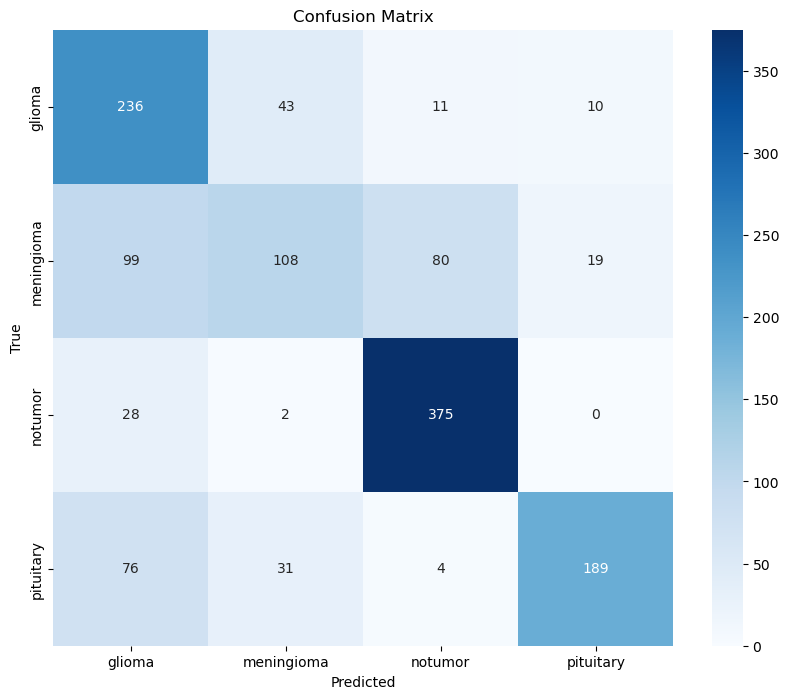

In [12]:
# Evaluate the Model

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.2%}")

# Predictions
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

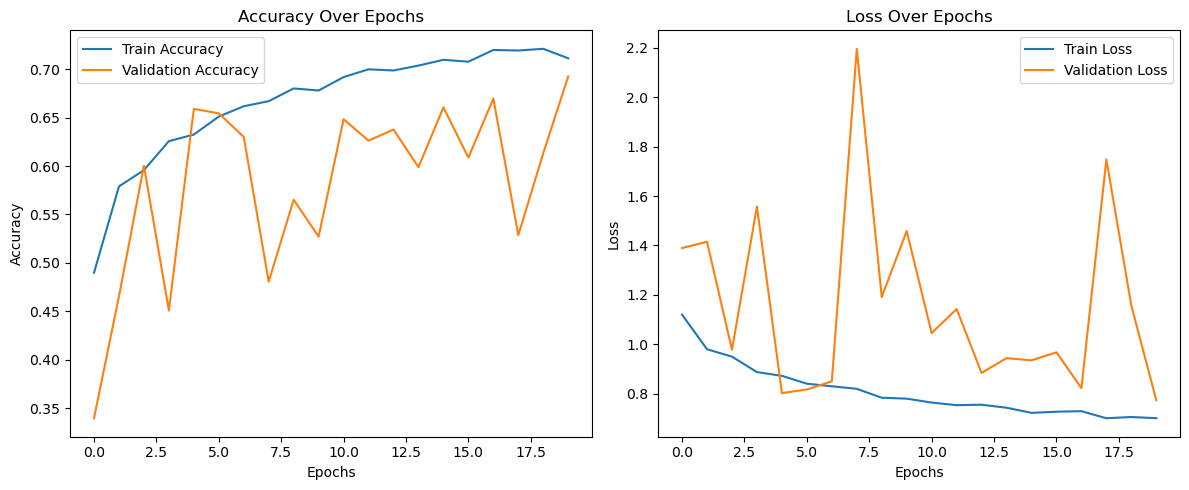

In [13]:
# Visualize Training History

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()

C:\Users\milto\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\milto\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_175. Received: the structure of inputs=['*']
  warnings.warn(


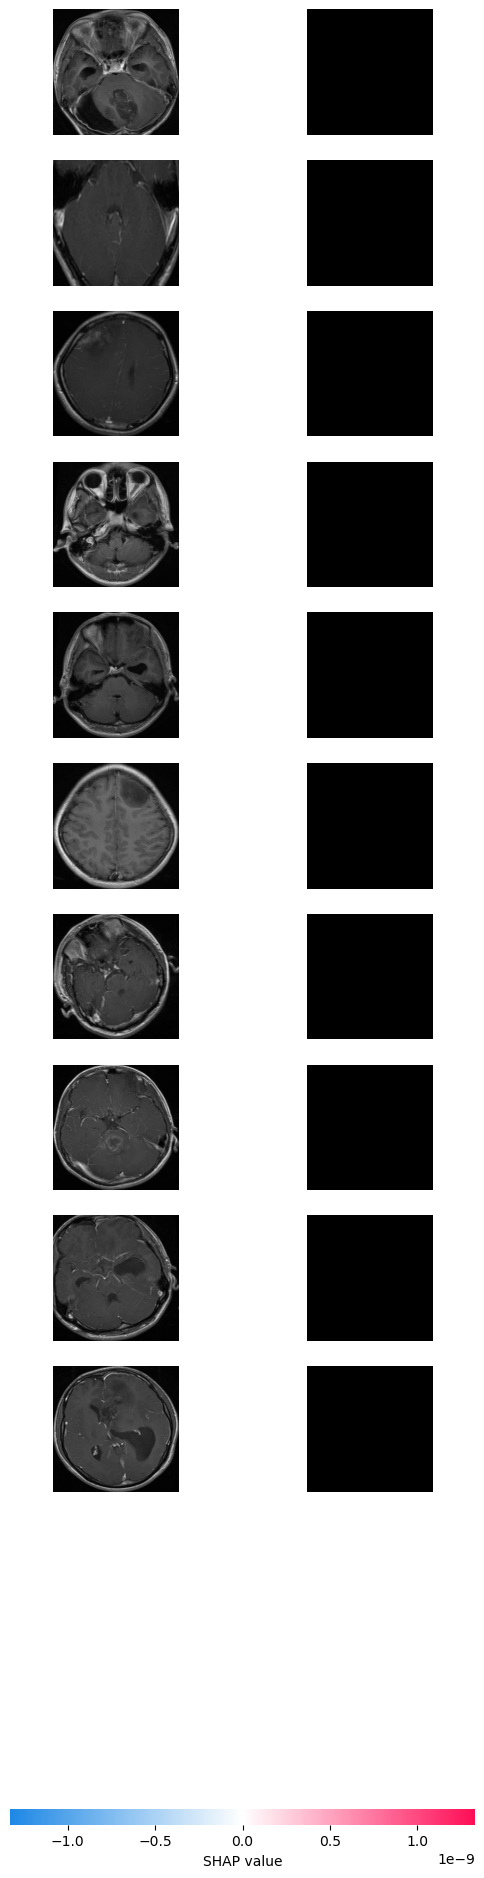

In [14]:
# Explainable AI with SHAP

# SHAP requires a small batch of test data
shap_sample_data, _ = next(test_generator)
shap_sample_data = shap_sample_data[:10]  # Use 10 images for SHAP

# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, shap_sample_data)
shap_values = explainer.shap_values(shap_sample_data)

# Visualize SHAP values
shap.image_plot(shap_values, shap_sample_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

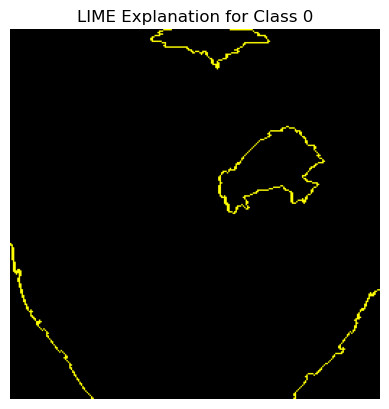

In [15]:
# Explainable AI with LIME

def lime_explain(model, data, sample_index):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        data[sample_index].astype('double'),
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation for Class {explanation.top_labels[0]}")
    plt.axis('off')
    plt.show()

# Run LIME on a sample
lime_explain(model, shap_sample_data, 0)

In [ ]:
# Better Generalization: Pre-trained models and class weights should improve classification metrics.
# Balanced Predictions: Class weights and better data augmentation mitigate bias toward dominant classes.
# Explainability: SHAP and LIME provide insights into predictions, helping refine preprocessing or model training.